<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-alignment-data" data-toc-modified-id="Load-alignment-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load alignment data</a></span></li><li><span><a href="#Copy-filtered-slide-images-to-new-folder" data-toc-modified-id="Copy-filtered-slide-images-to-new-folder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Copy filtered-slide images to new folder</a></span></li><li><span><a href="#Using-docarray-to-construct" data-toc-modified-id="Using-docarray-to-construct-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using <code>docarray</code> to construct</a></span></li><li><span><a href="#Baseline-models-construction" data-toc-modified-id="Baseline-models-construction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Baseline models construction</a></span></li><li><span><a href="#Training-set-and-Testing-set-spilt" data-toc-modified-id="Training-set-and-Testing-set-spilt-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training set and Testing set spilt</a></span></li><li><span><a href="#Model-Implementation(Baseline)" data-toc-modified-id="Model-Implementation(Baseline)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model Implementation(Baseline)</a></span><ul class="toc-item"><li><span><a href="#Textual-approach" data-toc-modified-id="Textual-approach-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Textual approach</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-(Textual)" data-toc-modified-id="Naive-Bayes-(Textual)-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Naive Bayes (Textual)</a></span></li><li><span><a href="#Evaluation-Textual-Results" data-toc-modified-id="Evaluation-Textual-Results-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Evaluation Textual Results</a></span></li></ul></li><li><span><a href="#Visual-approach" data-toc-modified-id="Visual-approach-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Visual approach</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-(Visual)" data-toc-modified-id="Naive-Bayes-(Visual)-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Naive Bayes (Visual)</a></span></li><li><span><a href="#Evaluation-Visual-Results" data-toc-modified-id="Evaluation-Visual-Results-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Evaluation Visual Results</a></span></li></ul></li><li><span><a href="#Multi-modal-approach" data-toc-modified-id="Multi-modal-approach-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Multi-modal approach</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes-(Multi-modal)" data-toc-modified-id="Naive-Bayes-(Multi-modal)-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Naive Bayes (Multi-modal)</a></span></li><li><span><a href="#Evaluation-Multi-modal-Results" data-toc-modified-id="Evaluation-Multi-modal-Results-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Evaluation Multi-modal Results</a></span></li></ul></li></ul></li></ul></div>

In [21]:
from typing import List
from docarray import dataclass, Document, DocumentArray
from docarray.typing import Image, Text, JSON, URI
import ast
import pandas as pd
import os
import numpy as np
import platform
import shutil
import re

is_windows = platform.system().lower() == 'windows'
# if is_windows:
#     source_dir = "C:\\Users\\Kun\\Desktop" 
# else:
#     source_dir = "/Users/kun-lin/Desktop"
source_dir = os.getcwd()


# source_dir = os.path.join(source_dir, f"Angebot")
dest_dir = "output"
PPTtoImg_dir = os.path.join(dest_dir, f"PPTtoImg")
fWordImg_dir = os.path.join(dest_dir, f"FewWordImg")
ct_fWordImg_dir = os.path.join(fWordImg_dir, f"CT_FewWordImg")
topshapetype_dir = os.path.join(dest_dir, f"TopShapeTypeImg")
labels_dir = os.path.join(dest_dir, f"LABELS")
checkpoint_path = os.path.join(dest_dir, f"checkpoints")

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
if not os.path.exists(PPTtoImg_dir):
    os.makedirs(PPTtoImg_dir)
if not os.path.exists(fWordImg_dir):
    os.makedirs(fWordImg_dir)
if not os.path.exists(ct_fWordImg_dir):
    os.makedirs(ct_fWordImg_dir)  
if not os.path.exists(topshapetype_dir):
    os.makedirs(topshapetype_dir)
if not os.path.exists(labels_dir):
    os.makedirs(labels_dir)
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

# Load alignment data

In [22]:
def convert_to_list(data):
    return ast.literal_eval(data)
# Since it take too much time on traversal ppt files, Easily to import the dataframe from the csv file
df_da = pd.read_csv('alignment_pptx_list.csv', converters={'shape_type': convert_to_list})
# for Mac OS
if not is_windows:
    df_da['file_name'] = df_da['file_name'].apply(lambda x: x.replace('C\\Users\\Kun\\Desktop\\Angebot', source_dir))
    df_da['file_name'] = df_da['file_name'].apply(lambda x: x.replace('\\', '/'))

df_da = df_da[~df_da['contents'].isnull()]
df_da.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26468 entries, 0 to 26467
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   26468 non-null  object
 1   page_num    26468 non-null  int64 
 2   shape_type  26468 non-null  object
 3   contents    26468 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB


In [23]:
# filter out less than 4 words
df_da['word_count'] = df_da['contents'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
df_few_words = df_da[~(df_da['word_count'] <= 4)]
df_few_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


In [24]:
df_json = pd.read_json(os.path.join(labels_dir, "backup_23148_4374.json"))
# have done for annotations
df_json = df_json[df_json['annotations'].apply(lambda x: len(x) != 0)]
# annotation results exist
df_json = df_json[df_json['annotations'].apply(lambda x: len(x[0]['result']) != 0)]
# 22348 for 13th slide
count = 13

df_few_words['label'] = ''

for idx, row in enumerate(df_json.iterrows()):
  slide = row[1]
  image_path = slide['data']['image']
  choice = slide['annotations'][0]['result'][0]['value']['choices'][0]
  # print(image_path, choice)
  if image_path.find('22348')!=-1:
    # print(image_path, choice)
    new_image_name = image_path.split('.')[0] + '_' + str(count) + '.PNG'
    slide['data']['image'] = new_image_name
    image_path = new_image_name
    print(image_path)
    count += 1

  # get page number
  if image_path.split('.')[0].split('_')[-1].isdigit():
    page = int(image_path.split('.')[0].split('_')[-1])
  else:
    page = 0

  # given 'Angebot\ktr' as a condition
  ktr = image_path.split('-')[1].split('_')[0]
  ktr = 'Angebot\\'+ ktr
  ktr = re.escape(ktr)

  # some issues that it should modify manually
  if (ktr == '22348' and page == 13):
    df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = 'Initial Situation'
    continue
  elif (ktr == '22348' and page == 14):
    df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = 'Target Situation'
    continue

  df_few_words.loc[(df_few_words['file_name'].str.contains(ktr)) & (df_few_words['page_num'] == page), 'label'] = choice

df_few_words.info()

C:\Users\Kun\AppData\Local\Temp\ipykernel_20172\246864648.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_few_words['label'] = ''


/data/upload/3/30b5074c-22348_Projektskizze_Benchmarking_und_Effizienzsteigerung_in_den_Zentra_EVP8fho_13.PNG
/data/upload/3/33344dac-22348_Projektskizze_Benchmarking_und_Effizienzsteigerung_in_den_Zentra_iHJAu6y_14.PNG
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23148 entries, 0 to 26467
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   23148 non-null  object
 1   page_num    23148 non-null  int64 
 2   shape_type  23148 non-null  object
 3   contents    23148 non-null  object
 4   word_count  23148 non-null  int64 
 5   label       23148 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [25]:
df_few_words[df_few_words['label'].isna()]

,file_name,page_num,shape_type,contents,word_count,label


In [26]:
df_few_words['label'].value_counts()

                               18778
Working Package Examples         668
Others                           607
Working Package Description      564
Reference Details                407
Consultant Profile               370
Offer Title                      365
Project Calculation              304
Initial & Target Situation       255
Working Package Overview         237
Reference Overview               215
Competencies                     189
Target Situation                 103
Initial Situation                 86
Name: label, dtype: int64

In [27]:
df_few_words = df_few_words[(df_few_words['label']!='') & (df_few_words['label']!='Others')]

# Copy filtered-slide images to new folder (FewWordImg)

In [ ]:
def delete_png_files(directory):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filename.lower().endswith(".PNG"):
            os.remove(filepath)

In [7]:
# copy filtered-data to new folder(FewWordImg)
delete_png_files(fWordImg_dir)
uni_path = df_few_words['file_name'].unique()

for path in uni_path:
    for idx, row in df_few_words[df_few_words['file_name'] == path].iterrows():
        # print(row['file_name'])
        exec_path = os.path.abspath(PPTtoImg_dir)  # image output path
        if is_windows:
            # for windows OS
            ktr = row['file_name'].split('\\')[-2]
        else:
            # for Mac OS
            ktr = row['file_name'].split('/')[-2]
        name = os.path.basename(row['file_name'])
        name = name.split('.')[0]
        name = '_'.join([ktr, name, "%d.PNG" % row['page_num']])
        imgpath = os.path.join(exec_path, name)
        
        # from PPTtoImg to FewWordImg
        shutil.copy(imgpath, os.path.join(os.getcwd(), fWordImg_dir))

> This process is to ignore **Chapter Covers** images so that we make them labeling easier

# Using `docarray` to construct

In [28]:
@dataclass
class MySlide:
    Content: Text #chunk
    ImgPath: Image #chunk
    ShapeType: List[str] #tag
    PageNum: int #tag
    Label: str #tag

@dataclass
class MyPPT:
    FileName: Text
    Slide: List[MySlide]

group_slide = DocumentArray()
uni_path = df_few_words['file_name'].unique()

for path in uni_path:
    for idx, row in df_few_words[df_few_words['file_name'] == path].iterrows():
        # print(row['file_name'])
        exec_path = os.path.abspath(fWordImg_dir)  # filter-images output path
        if is_windows:
            # for windows OS
            ktr = row['file_name'].split('\\')[-2]
        else:
            # for Mac OS
            ktr = row['file_name'].split('/')[-2]
        name = os.path.basename(row['file_name'])
        name = name.split('.')[0]
        name = '_'.join([ktr, name, "%d.PNG" % row['page_num']])
        imgpath = os.path.join(exec_path, name)
        # imgpath = os.path.join(image_dir_path, )
        
        m = MySlide(
                    Content = row['contents'],
                    ImgPath = imgpath,
                    ShapeType = row['shape_type'],
                    PageNum = row['page_num'],
                    Label = row['label']
                )
        
        group_slide.append(Document(m))
            
docPPT = Document(MyPPT(FileName = path, Slide = group_slide))

In [15]:
docPPT_1620 = Document(MyPPT(FileName=docPPT.FileName, Slide=[d for d in docPPT.Slide if d.tags['Label'] != ''and d.tags['Label'] != 'Others']))

# Baseline models construction

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, train_test_split, KFold

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# This function will print the metrcis for diffeent model
def print_model_report(y_test, prediction, ML_modelName):
    print("Model report for: "+ ML_modelName + "\n")
    print(classification_report(y_test, prediction, digits=4, target_names=['Competencies[0]', 
                                                                            'Consultant Profile[1]', 
                                                                            'Initial & Target Situation[2]', 
                                                                            'Initial Situation[3]', 
                                                                            'Offer Title[4]', 
                                                                            'Project Calculation[5]', 
                                                                            'Reference Details[6]', 
                                                                            'Reference Overview[7]',
                                                                            'Target Situation[8]',
                                                                            'Working Package Description[9]',
                                                                            'Working Package Examples[10]',
                                                                            'Working Package Overview[11]']))
    # print(classification_report(y_test, prediction, digits=4,))
    
# Show confusion matrix plot
def plot_confusion_matrix(y_test, prediction, ML_modelName, cmap):
    cm = confusion_matrix(y_test, prediction)
    
    ax = sns.heatmap(cm, 
              annot=True, 
              annot_kws={'size':18,'weight':'normal'},
              fmt='.20g', 
              cmap=cmap, 
              cbar_kws={'shrink':1},
              linewidths=2)
    
    plt.title("Confusion Matrix for: " + ML_modelName)
    plt.ylabel("Actual Label")
    plt.xlabel("Predict Label")
    cbar = ax.collections[0].colorbar
    plt.show()
    
    
def stratifiedVD(X_train, y_train, ex_model):
    #StratifiedKFold is a variation of KFold
    SKF = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X_train, y_train)
    score_list = []
    for k, (train, test) in enumerate(SKF):

        print(train.shape, test.shape)
        # instantiate the model
        ex_model.fit(X_train.iloc[train], y_train.iloc[train])
        # calculate the score each fold
        score = ex_model.score(X_train.iloc[test], y_train.iloc[test])
        score_list.append(score)

        print(f'Fold: {k+1:2d}, Class dist.: {np.bincount(y_train.iloc[train])}, Acc: {score:.3f}')    

    print(f'\nCV accuracy: {np.mean(score_list):.3f} +/- {np.std(score_list):.3f}')
    

def evaluate_model(X, y, pipline):
    # instantiate the model
    # RSKF = RepeatedStratifiedKFold(n_splits=10, random_state=42, n_repeats=3)
    SKF = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    scores = cross_val_score(pipline, X, y, cv= SKF, scoring='accuracy', n_jobs=-1)
    return scores


def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        # roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average= average , multi_class="ovr")

        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

# Training set and Testing set spilt

In [30]:
# dict_augment = {'ori':docPPT.Slide, 'slide_1620':docPPT_1620.Slide}
dict_augment = {'ori':docPPT.Slide}

In [31]:
# given textual or visual information as X variable and the category as y variable
def get_X_y_set(dict_aug):
    dict_ = dict()
    for str, da in dict_aug.items():
        X_text = da['@.[Content]'].to_dataframe().text
        X_shape = pd.Series([slide.tags['ShapeType'] for slide in da])
        y = pd.Series([slide.tags['Label'] for slide in da])
        print(str, X_text.shape, X_shape.shape, y.shape)
        dict_[str] = pd.DataFrame({'X_text': X_text, 'X_shape': X_shape, 'y': y})
        
    return dict_

dict_X_y = get_X_y_set(dict_augment)

ori (3763,) (3763,) (3763,)


In [32]:
dict_X_y['ori']

,X_text,X_shape,y
0,iCert 20 Change Management Design Sprint Sup...,"[PICTURE, FREEFORM, TEXT_BOX]",Offer Title
1,B Intranet Create content and setup concept s...,"[PLACEHOLDER, AUTO_SHAPE, FREEFORM, TABLE, GRO...",Working Package Overview
2,Thematic Focus Transformation change managemen...,"[LINE, PICTURE, PLACEHOLDER, AUTO_SHAPE, TEXT_...",Consultant Profile
3,Secure Life Cycle Management LCM Process Enclo...,"[PICTURE, PLACEHOLDER, AUTO_SHAPE, TEXT_BOX, E...",Offer Title
4,Hamilton provides intelligent ventilation prod...,"[LINE, PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEF...",Initial & Target Situation
...,...,...,...
3758,6079 Heinrich Meintrup Executive Vice Presiden...,"[TEXT_BOX, AUTO_SHAPE]",Reference Details
3759,9561 Analysis and critical review of the curre...,"[TEXT_BOX, AUTO_SHAPE]",Reference Details
3760,PPMRail project KnorrBremse is consolidating a...,"[LINE, PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEF...",Initial & Target Situation
3761,Evaluate the scope of the implemented function...,"[PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEFORM, G...",Working Package Overview


In [33]:
keys = 'ori'
dict_X_y[keys]['y'].value_counts()

Working Package Examples       668
Working Package Description    564
Reference Details              407
Consultant Profile             370
Offer Title                    365
Project Calculation            304
Initial & Target Situation     255
Working Package Overview       237
Reference Overview             215
Competencies                   189
Target Situation               103
Initial Situation               86
Name: y, dtype: int64

In [34]:
df_features = pd.DataFrame.from_dict(dict_X_y[keys])

labelencoder = LabelEncoder()
# df_features['y_encoded'] = labelencoder.fit_transform(dict_X_y[keys]['y'])
df_features['y_encoded'] = labelencoder.fit_transform(df_features['y'])
features = [c for c in df_features.columns.values if c not in ['y', 'y_encoded']]
features

['X_text', 'X_shape']

In [35]:
# Train and Test data splits
X_train, X_test, y_train, y_test = train_test_split(df_features[features], df_features['y_encoded'], test_size=0.1,
                                                    stratify=df_features['y_encoded'], random_state=42, shuffle=True)

In [36]:
df_features['y_encoded'].value_counts()

10    668
9     564
6     407
1     370
4     365
5     304
2     255
11    237
7     215
0     189
8     103
3      86
Name: y_encoded, dtype: int64

# Model Implementation(Baseline)

## Textual approach

In [37]:
# bag of words for chi square
# vectorize_cal = CountVectorizer(max_df= 0.85, min_df=2)
vectorize_cal = CountVectorizer()
sparse_matrix = vectorize_cal.fit_transform(X_train['X_text'], y_train)

df_bow=pd.DataFrame(sparse_matrix.toarray(), columns=vectorize_cal.get_feature_names_out())
# df_bow
k_best_cal = SelectKBest(score_func = chi2, k = 2700)
best_matrix = k_best_cal.fit(df_bow, y_train)

cols = best_matrix.get_support(indices=True)
features_df_new = df_bow.iloc[:,cols]
features_df_new.index = X_train['X_text'].index
features_df_new

,01,01102021,02,03,04,05,08,09,10,100,...,öffentlicher,über,übergabe,übergeordnetes,überschrift,übersicht,übertragung,überwachung,überweisung,überzeugten
765,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1761,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
764,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1096,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2872,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Naive Bayes (Textual)

In [38]:
pipeline_nb_t = Pipeline([('vect', CountVectorizer()),
                          ('chi', SelectKBest(score_func = chi2, k = 4500)),
                          ('tfidf', TfidfTransformer()),
                          ('model', MultinomialNB())])


model_nb_t = pipeline_nb_t.fit(X_train['X_text'], y_train)


### Evaluation Textual Results

In [39]:
stratifiedVD(X_train['X_text'], y_train, model_nb_t)

(3047,) (339,)
Fold:  1, Class dist.: [153 300 206  69 295 247 329 175  84 458 540 191], Acc: 0.764
(3047,) (339,)
Fold:  2, Class dist.: [153 300 206  69 295 246 329 175  84 457 541 192], Acc: 0.746
(3047,) (339,)
Fold:  3, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.726
(3047,) (339,)
Fold:  4, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.723
(3047,) (339,)
Fold:  5, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.746
(3047,) (339,)
Fold:  6, Class dist.: [153 300 206  69 295 247 330 174  83 457 541 192], Acc: 0.773
(3048,) (338,)
Fold:  7, Class dist.: [153 300 206  69 295 247 330 175  83 457 541 192], Acc: 0.731
(3048,) (338,)
Fold:  8, Class dist.: [153 299 206  69 296 247 330 175  83 457 541 192], Acc: 0.713
(3048,) (338,)
Fold:  9, Class dist.: [153 299 206  69 296 247 330 175  84 457 541 191], Acc: 0.743
(3048,) (338,)
Fold: 10, Class dist.: [153 299 207  69 295 247 329 175  84 458 541 191], Acc: 0.757


In [40]:
pred_nb_t = model_nb_t.predict(X_test['X_text'])

Model report for: Naive Bayes (Textual)

                                precision    recall  f1-score   support

               Competencies[0]     1.0000    0.7895    0.8824        19
         Consultant Profile[1]     0.9024    1.0000    0.9487        37
 Initial & Target Situation[2]     0.6364    0.5385    0.5833        26
          Initial Situation[3]     1.0000    0.1111    0.2000         9
                Offer Title[4]     1.0000    0.9730    0.9863        37
        Project Calculation[5]     1.0000    0.9000    0.9474        30
          Reference Details[6]     0.9024    0.9024    0.9024        41
         Reference Overview[7]     1.0000    0.6190    0.7647        21
           Target Situation[8]     0.0000    0.0000    0.0000        10
Working Package Description[9]     0.5465    0.8393    0.6620        56
  Working Package Examples[10]     0.6559    0.9104    0.7625        67
  Working Package Overview[11]     1.0000    0.0833    0.1538        24

                     

c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


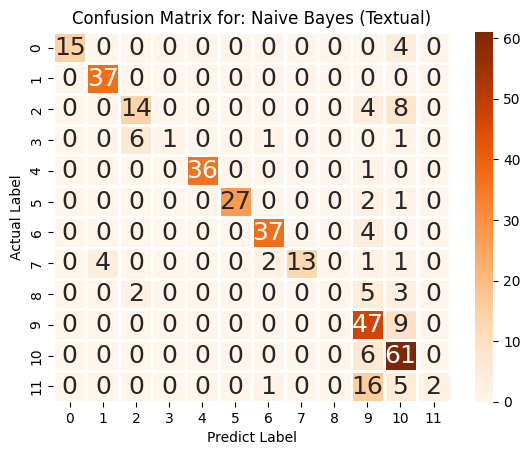

{0: 0.8947368421052632,
 1: 0.9941176470588236,
 2: 0.7578347578347578,
 3: 0.5555555555555556,
 4: 0.9864864864864865,
 5: 0.95,
 6: 0.945267131242741,
 7: 0.8095238095238095,
 8: 0.5,
 9: 0.8588951935914554,
 10: 0.9036109773712084,
 11: 0.5416666666666666}

In [41]:
print_model_report(y_test, pred_nb_t, "Naive Bayes (Textual)")
plot_confusion_matrix(y_test, pred_nb_t, "Naive Bayes (Textual)", plt.cm.Oranges)
roc_auc_score_multiclass(y_test, pred_nb_t)

## Visual approach

In [42]:
types = ['AUTO_SHAPE', 'CALLOUT', 'CANVAS', 'CHART',
        'COMMENT', 'DIAGRAM', 'EMBEDDED_OLE_OBJECT', 'FORM_CONTROL',
        'FREEFORM', 'GROUP', 'IGX_GRAPHIC', 'INK', 'INK_COMMENT',
        'LINE', 'LINKED_OLE_OBJECT', 'LINKED_PICTURE', 'MEDIA',
        'OLE_CONTROL_OBJECT', 'PICTURE', 'PLACEHOLDER', 'SCRIPT_ANCHOR',
        'TABLE', 'TEXT_BOX', 'TEXT_EFFECT', 'WEB_VIDEO', 'MIXED']

mlb = MultiLabelBinarizer(classes=types)
onehot = mlb.fit_transform(X_train['X_shape'])
df_shapes = pd.DataFrame(onehot, columns=mlb.classes_, index=X_train['X_shape'].index)
df_shapes

,AUTO_SHAPE,CALLOUT,CANVAS,CHART,COMMENT,DIAGRAM,EMBEDDED_OLE_OBJECT,FORM_CONTROL,FREEFORM,GROUP,...,MEDIA,OLE_CONTROL_OBJECT,PICTURE,PLACEHOLDER,SCRIPT_ANCHOR,TABLE,TEXT_BOX,TEXT_EFFECT,WEB_VIDEO,MIXED
765,1,0,0,0,0,0,0,0,1,1,...,0,0,1,1,0,0,0,0,0,0
1761,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1305,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
764,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1096,1,0,0,0,0,0,0,0,1,1,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,0,0,0,0
612,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,1,0,0,0
2872,1,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,1,0,0,0
698,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0


### Naive Bayes (Visual)

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin

class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classes):
        self.mlb = MultiLabelBinarizer(classes=classes)
        self.classes = classes 

    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self
    
    def transform(self, X):
        return self.mlb.transform(X)

pipeline_nb_v = Pipeline([
    ('mlb_transformer', MultiLabelBinarizerTransformer(classes=types)),
    ('model', MultinomialNB())
])

model_nb_v = pipeline_nb_v.fit(X_train['X_shape'], y_train)

### Evaluation Visual Results

In [69]:
stratifiedVD(X_train['X_shape'], y_train, model_nb_v)

(3047,) (339,)
Fold:  1, Class dist.: [153 300 206  69 295 247 329 175  84 458 540 191], Acc: 0.605
(3047,) (339,)
Fold:  2, Class dist.: [153 300 206  69 295 246 329 175  84 457 541 192], Acc: 0.655
(3047,) (339,)
Fold:  3, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.628
(3047,) (339,)
Fold:  4, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.602
(3047,) (339,)
Fold:  5, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.602
(3047,) (339,)
Fold:  6, Class dist.: [153 300 206  69 295 247 330 174  83 457 541 192], Acc: 0.602
(3048,) (338,)
Fold:  7, Class dist.: [153 300 206  69 295 247 330 175  83 457 541 192], Acc: 0.598
(3048,) (338,)
Fold:  8, Class dist.: [153 299 206  69 296 247 330 175  83 457 541 192], Acc: 0.577
(3048,) (338,)
Fold:  9, Class dist.: [153 299 206  69 296 247 330 175  84 457 541 191], Acc: 0.636
(3048,) (338,)
Fold: 10, Class dist.: [153 299 207  69 295 247 329 175  84 458 541 191], Acc: 0.589


In [70]:
pred_nb_v = model_nb_v.predict(X_test['X_shape'])

Model report for: Naive Bayes (Visual)

                                precision    recall  f1-score   support

               Competencies[0]     0.0000    0.0000    0.0000        19
         Consultant Profile[1]     0.8966    0.7027    0.7879        37
 Initial & Target Situation[2]     0.7222    0.5000    0.5909        26
          Initial Situation[3]     0.0000    0.0000    0.0000         9
                Offer Title[4]     0.8158    0.8378    0.8267        37
        Project Calculation[5]     0.9310    0.9000    0.9153        30
          Reference Details[6]     0.8293    0.8293    0.8293        41
         Reference Overview[7]     0.0000    0.0000    0.0000        21
           Target Situation[8]     0.0000    0.0000    0.0000        10
Working Package Description[9]     0.5250    0.7500    0.6176        56
  Working Package Examples[10]     0.3662    0.7761    0.4976        67
  Working Package Overview[11]     0.0000    0.0000    0.0000        24

                      

c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


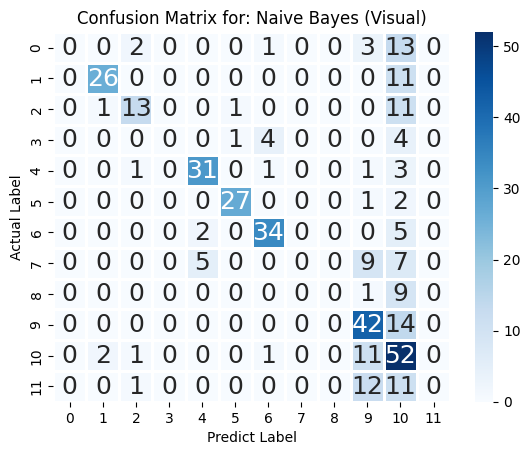

{0: 0.5,
 1: 0.846939586645469,
 2: 0.7428774928774929,
 3: 0.5,
 4: 0.90862480127186,
 5: 0.9471181556195966,
 6: 0.9042174796747967,
 7: 0.5,
 8: 0.5,
 9: 0.815809968847352,
 10: 0.7428984111699567,
 11: 0.5}

In [71]:
print_model_report(y_test, pred_nb_v, "Naive Bayes (Visual)")
plot_confusion_matrix(y_test, pred_nb_v, "Naive Bayes (Visual)", plt.cm.Blues)
roc_auc_score_multiclass(y_test, pred_nb_v)

## Multi-modal approach

### Naive Bayes (Multi-modal)

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin


class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class ShapeSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on shape columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classes):
        self.mlb = MultiLabelBinarizer(classes=classes)
        self.classes = classes
        
    def fit(self, X, y=None):
        self.mlb.fit(X)
        return self
    
    def transform(self, X):
        return self.mlb.transform(X)    

types = ['AUTO_SHAPE', 'CALLOUT', 'CANVAS', 'CHART',
        'COMMENT', 'DIAGRAM', 'EMBEDDED_OLE_OBJECT', 'FORM_CONTROL',
        'FREEFORM', 'GROUP', 'IGX_GRAPHIC', 'INK', 'INK_COMMENT',
        'LINE', 'LINKED_OLE_OBJECT', 'LINKED_PICTURE', 'MEDIA',
        'OLE_CONTROL_OBJECT', 'PICTURE', 'PLACEHOLDER', 'SCRIPT_ANCHOR',
        'TABLE', 'TEXT_BOX', 'TEXT_EFFECT', 'WEB_VIDEO', 'MIXED']
    


In [76]:
pipeline_text_sel=Pipeline([('selector', TextSelector(key='X_text')),
                            ('vect', CountVectorizer()),
                            ('chi', SelectKBest(score_func = chi2, k = 2500)),
                            ('tfidf', TfidfTransformer()),
                    ])

text_base = pipeline_text_sel.fit_transform(X_train, y_train)

pipeline_shape_sel=Pipeline([
    ('selector', ShapeSelector(key='X_shape')),
    ('mlb_transformer', MultiLabelBinarizerTransformer(classes=types)),
])

shape_type = pipeline_shape_sel.fit_transform(X_train, y_train)

In [77]:
from sklearn.pipeline import FeatureUnion
feats = FeatureUnion([
    ('text', pipeline_text_sel),
    ('shape', pipeline_shape_sel),
])

pipline_feature_processing = Pipeline([('feats', feats)])
feature_processing=pipline_feature_processing.fit_transform(X_train, y_train)

In [78]:
pipeline = Pipeline([
    ('features',feats),
    ('model', MultinomialNB()),
])
model_nb_mm = pipeline.fit(X_train, y_train)

### Evaluation Multi-modal Results

In [79]:
stratifiedVD(X_train, y_train, model_nb_mm)

(3047,) (339,)
Fold:  1, Class dist.: [153 300 206  69 295 247 329 175  84 458 540 191], Acc: 0.749
(3047,) (339,)
Fold:  2, Class dist.: [153 300 206  69 295 246 329 175  84 457 541 192], Acc: 0.746
(3047,) (339,)
Fold:  3, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.735
(3047,) (339,)
Fold:  4, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.720
(3047,) (339,)
Fold:  5, Class dist.: [153 300 206  70 295 246 329 174  84 457 541 192], Acc: 0.758
(3047,) (339,)
Fold:  6, Class dist.: [153 300 206  69 295 247 330 174  83 457 541 192], Acc: 0.785
(3048,) (338,)
Fold:  7, Class dist.: [153 300 206  69 295 247 330 175  83 457 541 192], Acc: 0.734
(3048,) (338,)
Fold:  8, Class dist.: [153 299 206  69 296 247 330 175  83 457 541 192], Acc: 0.695
(3048,) (338,)
Fold:  9, Class dist.: [153 299 206  69 296 247 330 175  84 457 541 191], Acc: 0.757
(3048,) (338,)
Fold: 10, Class dist.: [153 299 207  69 295 247 329 175  84 458 541 191], Acc: 0.749


In [80]:
pred_nb_mm = model_nb_mm.predict(X_test)

Model report for: Naive Bayes (Multi-modal)

                                precision    recall  f1-score   support

               Competencies[0]     1.0000    0.6842    0.8125        19
         Consultant Profile[1]     1.0000    1.0000    1.0000        37
 Initial & Target Situation[2]     0.6667    0.4615    0.5455        26
          Initial Situation[3]     0.0000    0.0000    0.0000         9
                Offer Title[4]     1.0000    0.9459    0.9722        37
        Project Calculation[5]     1.0000    0.9333    0.9655        30
          Reference Details[6]     0.9286    0.9512    0.9398        41
         Reference Overview[7]     1.0000    0.5238    0.6875        21
           Target Situation[8]     1.0000    0.2000    0.3333        10
Working Package Description[9]     0.6806    0.8750    0.7656        56
  Working Package Examples[10]     0.5385    0.9403    0.6848        67
  Working Package Overview[11]     1.0000    0.0833    0.1538        24

                 

c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kun\miniconda3\envs\UNITY39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


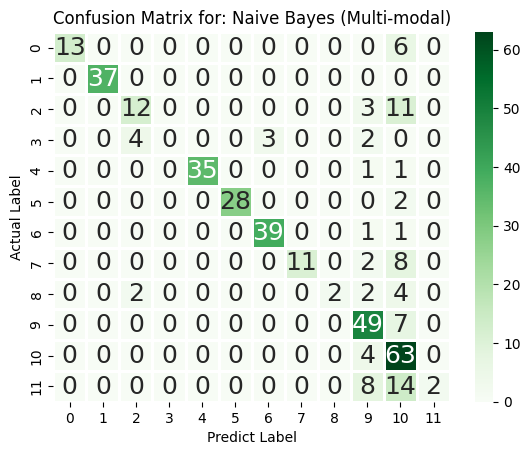

{0: 0.8421052631578947,
 1: 1.0,
 2: 0.7222222222222223,
 3: 0.5,
 4: 0.972972972972973,
 5: 0.9666666666666667,
 6: 0.9711454703832754,
 7: 0.7619047619047619,
 8: 0.6,
 9: 0.9016744548286604,
 10: 0.8830524795377949,
 11: 0.5416666666666666}

In [81]:
print_model_report(y_test, pred_nb_mm, "Naive Bayes (Multi-modal)")
plot_confusion_matrix(y_test, pred_nb_mm, "Naive Bayes (Multi-modal)", plt.cm.Greens)
roc_auc_score_multiclass(y_test, pred_nb_mm)

## Aggregate results

[0] Competencies: 19
[1] Consultant Profile: 37
[2] Initial & Target Situation: 26
[3] Initial Situation: 9
[4] Offer Title: 37
[5] Project Calculation: 30
[6] Reference Details: 41
[7] Reference Overview: 21
[8] Target Situation: 10
[9] Working Package Description: 56
[10] Working Package Examples: 67
[11] Working Package Overview: 24


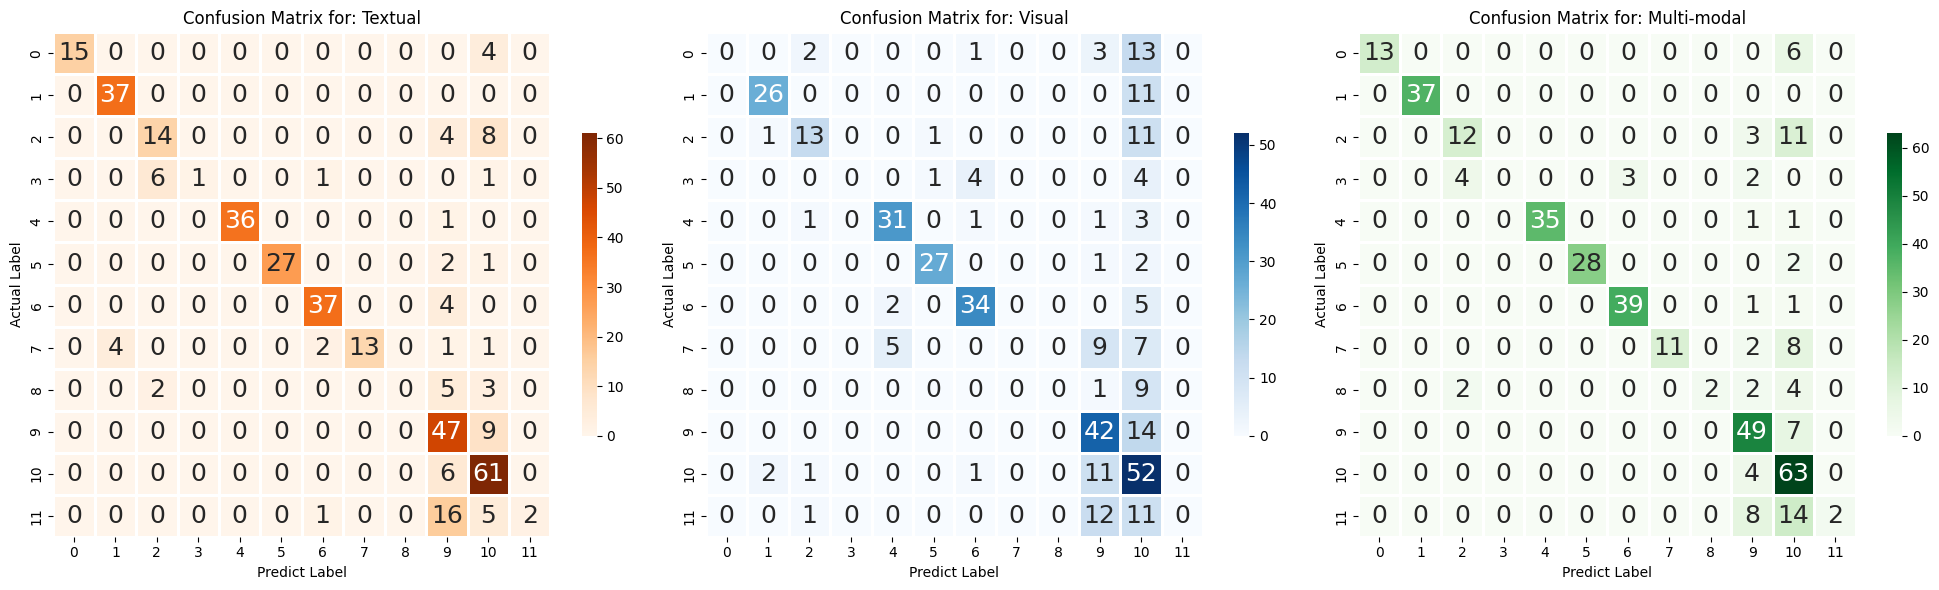

In [82]:
def plot_confusion_matrices(y_test, predictions, model_names, cmap):
    combined_cm = []
    for i, prediction in enumerate(predictions):
        cm = confusion_matrix(y_test, prediction)
        combined_cm.append(cm)
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

    for i, ax in enumerate(axs.flat):
        sns.heatmap(combined_cm[i], 
                    annot=True, 
                    annot_kws={'size':18,'weight':'normal'},
                    fmt='.20g', 
                    cmap=cmap[i], 
                    cbar_kws={'shrink':0.6},
                    linewidths=2,
                    ax=ax)
        ax.set_title("Confusion Matrix for: " + model_names[i])
        ax.set_ylabel("Actual Label")
        ax.set_xlabel("Predict Label")
    fig.tight_layout()
    plt.show()


models = ["Textual", "Visual", "Multi-modal"]
preds = [pred_nb_t, pred_nb_v, pred_nb_mm]
colors = [plt.cm.Oranges, plt.cm.Blues, plt.cm.Greens]

labels_name = ['Competencies', 
               'Consultant Profile', 
               'Initial & Target Situation', 
               'Initial Situation', 
               'Offer Title', 
               'Project Calculation', 
               'Reference Details', 
               'Reference Overview',
               'Target Situation',
               'Working Package Description',
               'Working Package Examples',
               'Working Package Overview']

for i, label in enumerate(labels_name):
    num = y_test.value_counts().sort_index()
    print(f"[{i}] {label}: {num[i]}")

plot_confusion_matrices(y_test, preds, models, colors)

> Confusion Matrix for three approach types (Textual, Visual, Multi-Modal) reveals suboptimal model performance due to imbalanced testing data in the following categories: **Competencies[0]**, **Initial & Target Situation[2]**, **Initial Situation[3]**, **Reference Overview[7]**, **Target Situation[8]**, **Working Package Overview[11]**. To address this issue, we should adjust the distribution of label data and retrain the model.

> Imbalance may affect model exhibit a bias towards predicting class more frequently, it has more examples to learn from majority labels and may struggle to accurately capture the patterns in other minor labels.

In [56]:
X_train

,X_text,X_shape
765,Im Rahmen der Initiative zur Einführung von Sy...,"[LINE, PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEF..."
1761,Geschäftsmodellworkshops OWL live Anlage 1 Lei...,"[PICTURE, FREEFORM, TEXT_BOX, AUTO_SHAPE]"
1305,Projektorganisation Potenzielles Projektteam P...,"[PLACEHOLDER, TEXT_BOX, LINE, AUTO_SHAPE]"
764,Operationalisierung Systems Engineering EA An...,"[PICTURE, AUTO_SHAPE, GROUP]"
1096,Ausgangssituation Zielsetzung Ausgangssituati...,"[LINE, PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEF..."
...,...,...
510,Academy ONE Training Ongoing organization of ...,"[PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEFORM, G..."
612,Test Unterstützung Schulung Inbetriebnahme Rea...,"[PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEFORM, G..."
2872,IstAufnahme Lieferantenportfolio Übernahme vor...,"[PICTURE, PLACEHOLDER, AUTO_SHAPE, FREEFORM, G..."
698,Themenschwerpunkte Prozessmanagement und ITBer...,"[LINE, PICTURE, PLACEHOLDER, AUTO_SHAPE, TEXT_..."


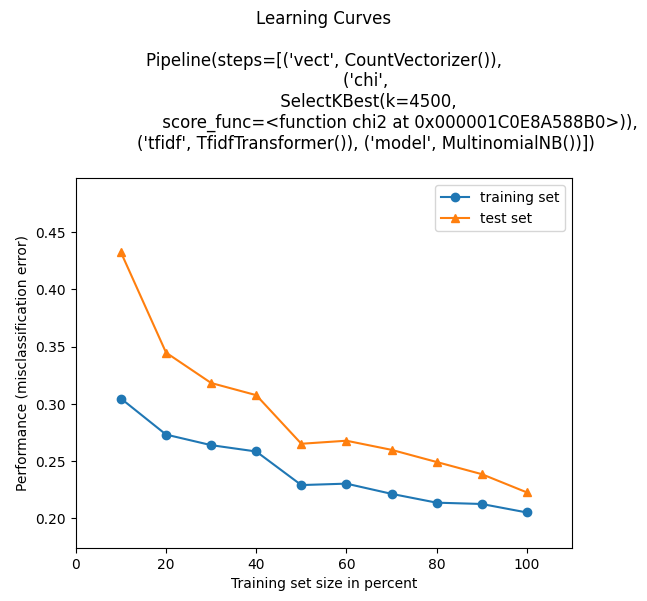

In [84]:
from mlxtend.plotting import plot_learning_curves

plot_learning_curves(X_train['X_text'], y_train, X_test['X_text'], y_test, model_nb_t,)
plt.show()

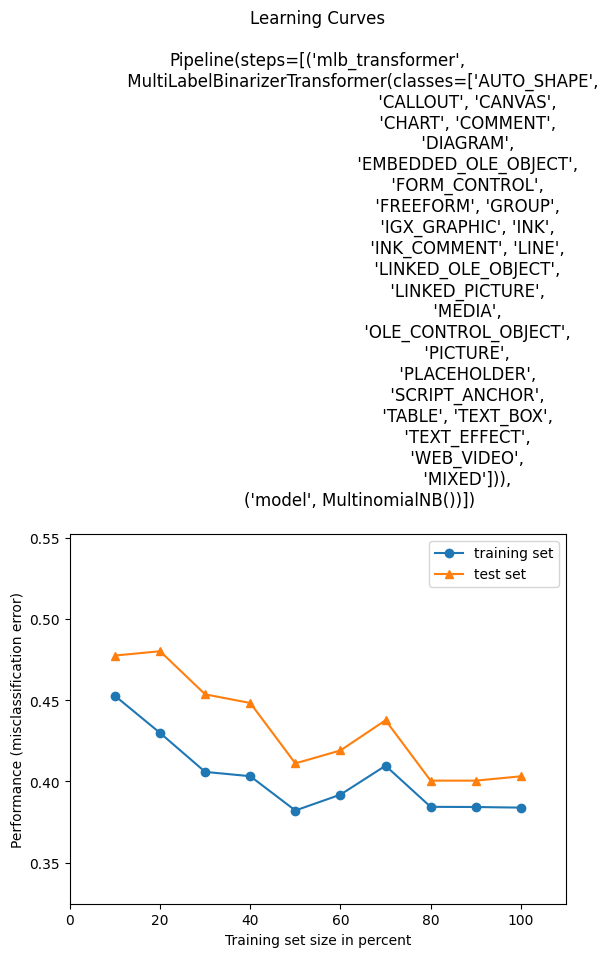

In [85]:
plot_learning_curves(X_train['X_shape'], y_train, X_test['X_shape'], y_test, model_nb_v)
plt.show()

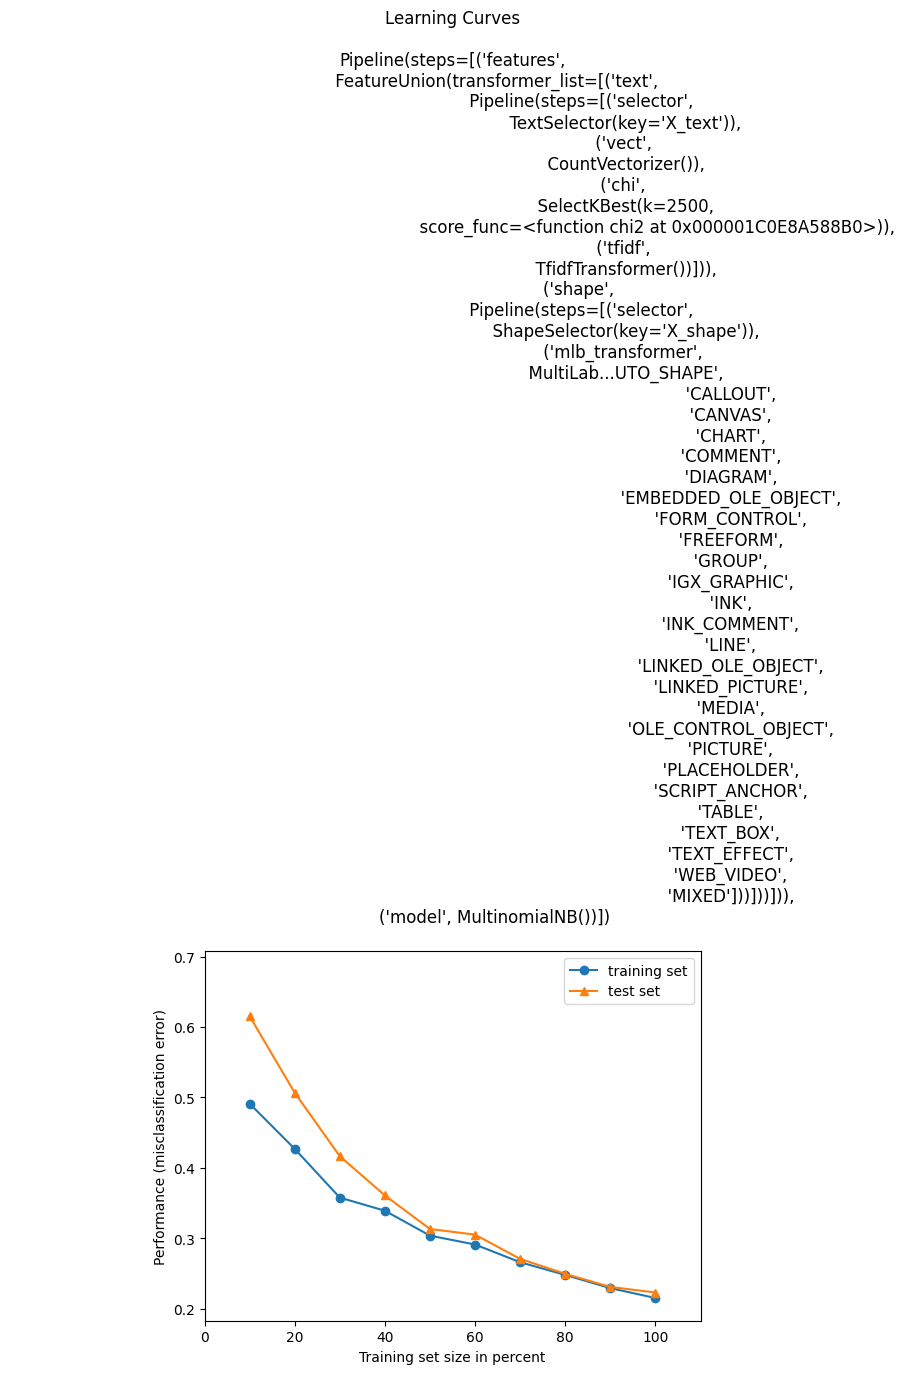

In [86]:
plot_learning_curves(X_train, y_train, X_test, y_test, model_nb_mm)
plt.show()